               Model     Train MSE      Test MSE  Train R2   Test R2  \
0  Linear Regression  9.417452e+07  1.098737e+08  0.699952  0.607474   
1           CatBoost  3.733732e+07  4.264299e+07  0.881040  0.847657   

     Train MAE     Test MAE  
0  8379.983392  8899.000019  
1  5075.082713  5508.450110  


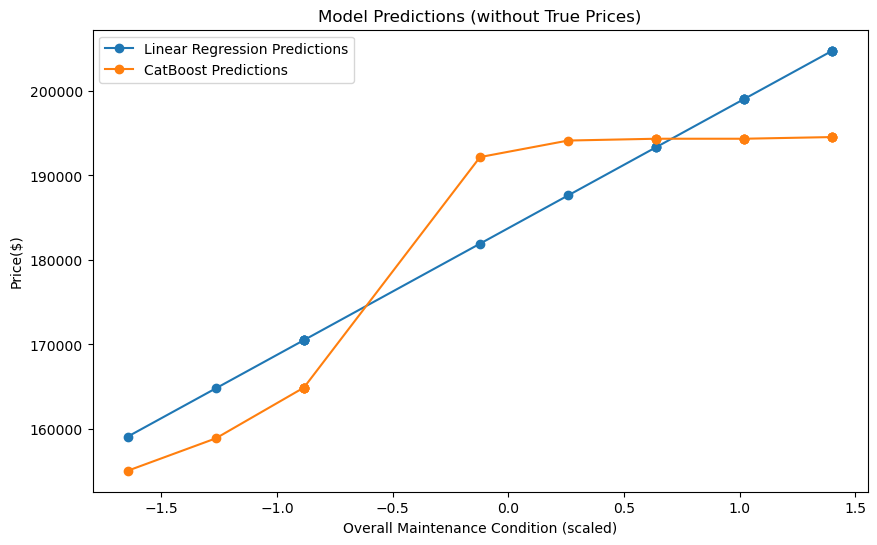

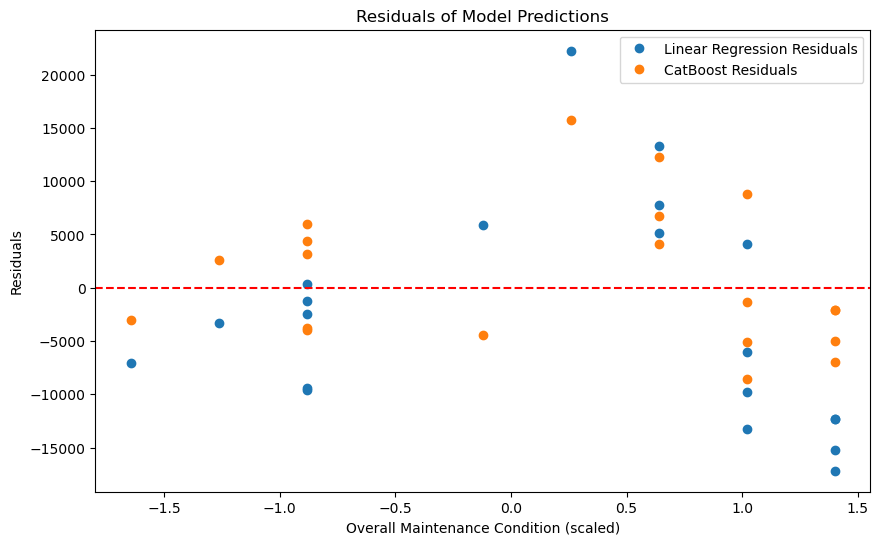

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

class ModelComparison:
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.X = self.data[['Overall_Maintenance_Condition']].values
        self.y = self.data['Price($)'].values
        self.scaler = StandardScaler()
        self.X_scaled = None
        self.models = {}

    def preprocess_data(self):
        """Normalize the feature using StandardScaler."""
        self.X_scaled = self.scaler.fit_transform(self.X)

    def train_models(self):
        """Train Linear Regression and CatBoost models with hyperparameter tuning."""
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(self.X_scaled, self.y, test_size=0.2, random_state=42)

        # Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        self.models['Linear Regression'] = {
            'model': lr_model,
            'X_train': X_train, 'X_test': X_test,
            'y_train': y_train, 'y_test': y_test,
            'y_train_pred': lr_model.predict(X_train),
            'y_test_pred': lr_model.predict(X_test)
        }

        # CatBoost Hyperparameter Tuning
        catboost_param_grid = {
            'iterations': [200, 500],
            'depth': [4, 6],
            'learning_rate': [0.1, 0.01],
            'verbose': [0],
            'monotone_constraints': [[1]]
        }
        catboost_model = CatBoostRegressor()
        catboost_grid = GridSearchCV(estimator=catboost_model, param_grid=catboost_param_grid, cv=3, scoring='neg_mean_squared_error')
        catboost_grid.fit(X_train, y_train)
        best_cb_model = catboost_grid.best_estimator_

        self.models['CatBoost'] = {
            'model': best_cb_model,
            'X_train': X_train, 'X_test': X_test,
            'y_train': y_train, 'y_test': y_test,
            'y_train_pred': best_cb_model.predict(X_train),
            'y_test_pred': best_cb_model.predict(X_test)
        }

    def calculate_metrics(self):
        """Calculate and display performance metrics."""
        results = []
        for model_name, model_data in self.models.items():
            train_mse = mean_squared_error(model_data['y_train'], model_data['y_train_pred'])
            test_mse = mean_squared_error(model_data['y_test'], model_data['y_test_pred'])
            train_r2 = r2_score(model_data['y_train'], model_data['y_train_pred'])
            test_r2 = r2_score(model_data['y_test'], model_data['y_test_pred'])
            train_mae = mean_absolute_error(model_data['y_train'], model_data['y_train_pred'])
            test_mae = mean_absolute_error(model_data['y_test'], model_data['y_test_pred'])

            results.append({
                'Model': model_name,
                'Train MSE': train_mse, 'Test MSE': test_mse,
                'Train R2': train_r2, 'Test R2': test_r2,
                'Train MAE': train_mae, 'Test MAE': test_mae
            })
        
        results_df = pd.DataFrame(results)
        print(results_df)
        
    def plot_results(self):
        """Plot predictions for both models (without true prices)."""
        plt.figure(figsize=(10, 6))
        
        for model_name, model_data in self.models.items():
            # Sort data for better plotting
            sorted_indices = np.argsort(model_data['X_test'].flatten())
            
            # Remove the plotting of true prices
            # plt.plot(model_data['X_test'][sorted_indices], model_data['y_test'][sorted_indices], 'o', label=f'{model_name} True Prices', alpha=0.5)
            
            # Plot predictions only
            plt.plot(model_data['X_test'][sorted_indices], model_data['y_test_pred'][sorted_indices], 
                     label=f'{model_name} Predictions', linestyle='-', marker='o')
        
        plt.xlabel('Overall Maintenance Condition (scaled)')
        plt.ylabel('Price($)')
        plt.title('Model Predictions (without True Prices)')
        plt.legend()
        plt.show()

    def plot_residuals(self):
        """Plot residuals for both models."""
        plt.figure(figsize=(10, 6))

        for model_name, model_data in self.models.items():
            residuals = model_data['y_test'] - model_data['y_test_pred']
            plt.plot(model_data['X_test'], residuals, 'o', label=f'{model_name} Residuals')

        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Overall Maintenance Condition (scaled)')
        plt.ylabel('Residuals')
        plt.title('Residuals of Model Predictions')
        plt.legend()
        plt.show()

# Usage
data_path = '/users/arash/desktop/maintenance_data.csv'  # Update this to your local data path
model_comp = ModelComparison(data_path)
model_comp.preprocess_data()
model_comp.train_models()
model_comp.calculate_metrics()
model_comp.plot_results()
model_comp.plot_residuals()
